In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import keras
import tensorflow
from keras import Sequential
from keras.layers import Dense
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics, svm
from sklearn.metrics import average_precision_score

Using TensorFlow backend.


In [44]:
df = pd.read_csv('COVID19_open_line_list.csv')

In [45]:
#df = df[pd.notnull(df['age'])]
#df = df[pd.notnull(df['sex'])]
#df = df[pd.notnull(df['country'])]
df = df[pd.notnull(df['symptoms'])]
#df = df[pd.notnull(df['lives_in_Wuhan'])]
df.drop(columns = ['city','province','latitude','longitude','geo_resolution','additional_information','source','sequence_available','outcome','notes_for_discussion','location','admin3','admin2','admin1','country_new','admin_id','data_moderator_initials'])

,ID,age,sex,country,wuhan(0)_not_wuhan(1),date_onset_symptoms,date_admission_hospital,date_confirmation,symptoms,lives_in_Wuhan,travel_history_dates,travel_history_location,reported_market_exposure,chronic_disease_binary,chronic_disease,date_death_or_discharge
30,6,NaN,NaN,China,1,NaN,NaN,24.01.2020,pneumonia,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,11,NaN,NaN,China,1,NaN,NaN,23.01.2020,pneumonia,NaN,NaN,NaN,NaN,NaN,NaN,NaN
243,10913,80-89,male,Japan,1,09.02.2020,NaN,18.02.2020,"dyspnea, fever",NaN,NaN,NaN,NaN,NaN,NaN,NaN
244,11272,80-89,female,Japan,1,22.01.2020,01.02.2020,13.02.2020,"anorexia, fatigue",NaN,NaN,NaN,NaN,NaN,NaN,13.02.2020
245,11553,80-89,male,Japan,1,27.01.2020,19.02.2020,21.02.2020,anorexia,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12372,12552,NaN,NaN,Japan,1,16.02.2020,25.02.2020,26.02.2020,cough,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12664,12892,NaN,NaN,Nigeria,1,NaN,NaN,27.02.2020,no serious symptoms,NaN,25.02.2020,"Milan, Italy",NaN,NaN,NaN,NaN
13186,13436,NaN,female,Sweden,1,NaN,NaN,27.02.2020,similar to a respiratory infection,no,NaN,Germany,NaN,NaN,NaN,NaN
13197,13478,NaN,female,Netherlands,1,NaN,NaN,28.02.2020,mild,NaN,NaN,returned from Italy this week,NaN,NaN,NaN,NaN


In [46]:
test = df.iloc[:,13]
symptom_set = set()
for row in list(test):
    row = str(row)
    l = row.split(",")
    for symp in l:
        symp = symp.strip()
        if symp == "nan":
            continue
        elif symp not in symptom_set:
            if "fever" in symp or "Fever" in symp:
                symptom_set.add("fever")
            else:
                symptom_set.add(symp)
        else:
            continue
print(symptom_set)

{'no serious symptoms', 'anhelation', 'sore limbs', 'no symptoms', 'sweating', 'expectoration', 'chest pain', 'severe dyspnea', 'similar to a respiratory infection', 'respiratory symptoms', 'headache.', 'shortness breath', 'no respiratory symptoms', 'chest tightness', 'conjunctivitis', 'acute pharyngitis', 'wheezing', 'Sore throat', 'dry throat', 'lack of energy', 'pharyngeal discomfort', 'rhinorrhea', 'cough; sore body; cold', 'sputum', 'discomfort', 'flu-like symptoms', 'muscle aches', 'rhinorrhoea', 'Pharyngeal dryness', 'myalgias', 'mild', 'diarrheoa', 'weakness', 'muscle soreness', 'diarrhoea', 'pneumonia', 'systemic weakness', 'feeling ill', 'Discharge', 'breathing difficulty', 'acute respiratory viral infection', 'mild coughing', 'Sputum', 'rever', 'Headache', 'muscular soreness', 'asymptomatic', 'fever', 'couh', 'toothache', 'then 38 ℃)', 'other symptoms', 'Fatigue', 'headache; dry mouth', 'fatigue', 'aching muscles', 'muscle pain', 'difficulty walking', 'difficulty breathing',

In [47]:
test = df.iloc[:,5]
country_dict = dict()
count = 0
for row in list(test):
    row = str(row)
    if row in country_dict:
        continue
    else:
        country_dict[row] = count
        count+= 1
print(country_dict)

{'China': 0, 'Japan': 1, 'nan': 2, 'United States': 3, 'Thailand': 4, 'Vietnam': 5, 'South Korea': 6, 'Singapore': 7, 'Malaysia': 8, 'Spain': 9, 'Cambodia': 10, 'Shaanxi': 11, 'France': 12, 'Lebanon': 13, 'Philippines': 14, 'Germany': 15, 'Lithuania': 16, 'Nepal': 17, 'Italy': 18, 'Russia': 19, 'Belgium': 20, 'Nigeria': 21, 'Sweden': 22, 'Netherlands': 23, 'Ecuador': 24}


In [48]:
cleanedData = []
count = 0
Count = 0
for index,row in df.iterrows():
    cur = []
    Count += 1
    '''
    # Clean the age column
    if str(row["age"]).isnumeric():
        #cur.append(int(row["age"]) // 10)
        cur += [0] * (int(row["age"]) // 10) + [1] + (9 - (int(row["age"]) // 10)) * [0]
    else:
        if "-" in row["age"]:
            loc = row["age"].index("-")
            #cur.append(int(row["age"][:loc]) // 10)
            cur += [0] * (int(row["age"][:loc]) // 10) + [1] + (9 - (int(row["age"][:loc]) // 10)) * [0]
        else:
            #cur.append(int(float(row["age"]) // 10))
            cur += [0] * ((int(float(row["age"]))) // 10) + [1] + (9 - ((int(float(row["age"]))) // 10)) * [0]
            
    '''
    # Clean the sex column
    if row["sex"] == "male":
        cur += [1,0]
    else:
        cur += [0,1]
    '''
    # Clean the country
    #cur.append(country_dict[str(row["country"])])
    cur += [0]*(country_dict[str(row["country"])]) + [1] + (26 -country_dict[str(row["country"])]) * [0]
    
    # Clean the Wuhan column, check whether they are citizens in Wuhan, 1 means not Wuhan
    cur.append(row["wuhan(0)_not_wuhan(1)"])
    # Clean the sympton date
    '''
    # Clean the sympton
    temp = str(row["symptoms"]).lower()
    # fever, cough, pneumonitis, fatigue
    # Fever- related
    if "fever" in temp or "headache" in temp:
        cur.append(1)
    else:
        cur.append(0)
    # Cough related
    if "cou" in temp or "throa" in temp or "dry" in temp or "pharyngeal" in temp or "expectoration" in temp or "flu" in temp:
        cur.append(1)
    else:
        cur.append(0)
    # Cold related
    if "chill" in temp or "nose" in temp or "nasal" in temp or "sneez" in temp:
        cur.append(1)
    else:
        cur.append(0)
    # pneumonitis related
    if "pneumon" in temp or "respiratory" in temp or "breath" in temp:
        cur.append(1)
    else:
        cur.append(0)
    # Muscle or fatigue, physical issue related
    if "fatigue" in temp or "myalgias" in temp or "musc" in temp or "walk" in temp or "chest" in temp or "limbs" in temp or "joint" in temp or "physical" in temp or "energy" in temp:
        cur.append(1)
    else:
        cur.append(0)
    # Stomacha related
    if "diarrhoea" in temp or "abdominal" in temp:
        cur.append(1)
    else:
        cur.append(0)
    # Other symptom or non-symptom
    if len(temp) > 0 and temp != "nan":
        cur.append(1)
    else:
        cur.append(0)
    
    # Clean the column whether live in Wuhan or have travel relations with Wuhan
    if str(row["lives_in_Wuhan"]).lower() == "nan" or str(row["lives_in_Wuhan"]).lower() == "no" or "wuhan" not in str(row["travel_history_location"]).lower():
        cur.append(0)
    else:
        cur.append(1)
        
    # Clean the target value: date_death_or_discharge
    if str(row["date_death_or_discharge"]).lower() == "nan":
        count += 1
        cur.append(0)
    else:
        cur.append(1)
    cleanedData.append(cur)
    
#print(count,Count)
#print(cleanedData)

In [50]:
import csv
f = open("NewCleanedConfirmedCase.csv", "a")
fieldnames = ['male','female','Fever','Cough','Cold','Pneumonitis','Fatigue','Stomacha','Other Symptoms','Relation with Wuhan','Death or Not']
writer = csv.DictWriter(f, fieldnames=fieldnames)
writer.writeheader()
writer = csv.writer(f)
writer.writerows(cleanedData)
f.close()

In [52]:
df = pd.read_csv("NewCleanedConfirmedCase.csv")

In [53]:
df

,male,female,Fever,Cough,Cold,Pneumonitis,Fatigue,Stomacha,Other Symptoms,Relation with Wuhan,Death or Not
0,0,1,0,0,0,1,0,0,1,0,0
1,0,1,0,0,0,1,0,0,1,0,0
2,1,0,1,0,0,0,0,0,1,0,0
3,0,1,0,0,0,0,1,0,1,0,1
4,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
489,0,1,0,1,0,0,0,0,1,0,0
490,0,1,0,0,0,0,0,0,1,0,0
491,0,1,0,0,0,1,0,0,1,0,0
492,0,1,0,0,0,0,0,0,1,0,0


In [57]:
X = df.iloc[:,:-1]
Y = df.iloc[:,-1]
print(X)
print(Y)

     male  female  Fever  Cough  Cold  Pneumonitis  Fatigue  Stomacha  \
0       0       1      0      0     0            1        0         0   
1       0       1      0      0     0            1        0         0   
2       1       0      1      0     0            0        0         0   
3       0       1      0      0     0            0        1         0   
4       1       0      0      0     0            0        0         0   
..    ...     ...    ...    ...   ...          ...      ...       ...   
489     0       1      0      1     0            0        0         0   
490     0       1      0      0     0            0        0         0   
491     0       1      0      0     0            1        0         0   
492     0       1      0      0     0            0        0         0   
493     0       1      1      0     0            0        0         0   

     Other Symptoms  Relation with Wuhan  
0                 1                    0  
1                 1                  

In [98]:
from sklearn.metrics import precision_recall_fscore_support
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1) 
# 80% training and 20% test
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
#print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# precision, recall ,f1, confusion matrix
precision_recall_fscore_support(y_test, y_pred, average='weighted')

(0.9501197542434656, 0.9595959595959596, 0.9530723905723905, None)

In [97]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
precision_recall_fscore_support(y_test, y_pred, average='weighted')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.9208244056728905, 0.9595959595959596, 0.9398104758929501, None)

In [2]:
# Another dataset set with much more records
from sklearn.utils import shuffle
df = pd.read_csv("Cleaned-Data.csv")
df

,Fever,Tiredness,Dry-Cough,Difficulty-in-Breathing,Sore-Throat,None_Sympton,Pains,Nasal-Congestion,Runny-Nose,Diarrhea,...,Gender_Male,Gender_Transgender,Severity_Mild,Severity_Moderate,Severity_None,Severity_Severe,Contact_Dont-Know,Contact_No,Contact_Yes,Country
0,1,1,1,1,1,0,1,1,1,1,...,1,0,1,0,0,0,0,0,1,China
1,1,1,1,1,1,0,1,1,1,1,...,1,0,1,0,0,0,0,1,0,China
2,1,1,1,1,1,0,1,1,1,1,...,1,0,1,0,0,0,1,0,0,China
3,1,1,1,1,1,0,1,1,1,1,...,1,0,0,1,0,0,0,0,1,China
4,1,1,1,1,1,0,1,1,1,1,...,1,0,0,1,0,0,0,1,0,China
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316795,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,1,0,1,0,Other
316796,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,1,1,0,0,Other
316797,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,1,0,0,0,1,Other
316798,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,1,0,0,1,0,Other


In [3]:
df = shuffle(df).sample(frac = 0.1)
df

,Fever,Tiredness,Dry-Cough,Difficulty-in-Breathing,Sore-Throat,None_Sympton,Pains,Nasal-Congestion,Runny-Nose,Diarrhea,...,Gender_Male,Gender_Transgender,Severity_Mild,Severity_Moderate,Severity_None,Severity_Severe,Contact_Dont-Know,Contact_No,Contact_Yes,Country
163271,1,0,0,0,0,0,0,0,0,1,...,0,1,0,0,1,0,1,0,0,Spain
122252,0,0,0,0,1,0,1,1,1,0,...,1,0,0,0,0,1,1,0,0,Republic of Korean
234824,1,1,1,0,0,0,0,0,0,0,...,1,0,0,0,0,1,1,0,0,UAE
36460,1,0,0,0,0,0,1,1,0,0,...,0,1,0,1,0,0,0,1,0,Italy
231226,0,1,1,0,0,0,0,0,1,1,...,0,0,0,0,1,0,0,1,0,UAE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208062,0,1,0,0,0,0,1,1,0,0,...,0,1,0,0,0,1,0,0,1,Germany
93241,1,1,1,0,0,0,0,1,1,1,...,0,1,1,0,0,0,0,1,0,Iran
161892,0,0,1,1,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,1,Spain
91613,0,1,1,1,0,0,1,1,1,1,...,0,0,0,1,0,0,1,0,0,Iran


In [58]:
Y = df[["Severity_Mild","Severity_Moderate","Severity_None","Severity_Severe"]] 
Y

Target = []
for index,row in Y.iterrows():
    if row["Severity_None"] == 1:
        Target.append(0)
    else:
        Target.append(1)
#Target

In [5]:
X = df.drop(["Severity_Mild","Severity_Moderate","Severity_None","Severity_Severe","Country"], axis = 1)
X

,Fever,Tiredness,Dry-Cough,Difficulty-in-Breathing,Sore-Throat,None_Sympton,Pains,Nasal-Congestion,Runny-Nose,Diarrhea,...,Age_10-19,Age_20-24,Age_25-59,Age_60+,Gender_Female,Gender_Male,Gender_Transgender,Contact_Dont-Know,Contact_No,Contact_Yes
163271,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,1,0,0
122252,0,0,0,0,1,0,1,1,1,0,...,0,0,0,1,0,1,0,1,0,0
234824,1,1,1,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0
36460,1,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,1,0,1,0
231226,0,1,1,0,0,0,0,0,1,1,...,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208062,0,1,0,0,0,0,1,1,0,0,...,0,1,0,0,0,0,1,0,0,1
93241,1,1,1,0,0,0,0,1,1,1,...,0,0,0,1,0,0,1,0,1,0
161892,0,0,1,1,0,0,0,1,1,0,...,0,0,0,0,1,0,0,0,0,1
91613,0,1,1,1,0,0,1,1,1,1,...,0,0,0,1,1,0,0,1,0,0


In [50]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
res = OneVsRestClassifier(LinearSVC(random_state=0)).fit(X, Target).predict(X)
count = 0
for index in range(len(Target)):
    if res[index] == Target[index]:
        count+= 1
print(count / len(Target))

0.7459280303030303


Train on 22176 samples, validate on 9504 samples
Epoch 1/1000
 - 1s - loss: 1.3892 - accuracy: 0.2449 - val_loss: 1.3874 - val_accuracy: 0.2507
Epoch 2/1000
 - 1s - loss: 1.3858 - accuracy: 0.2605 - val_loss: 1.3890 - val_accuracy: 0.2526
Epoch 3/1000
 - 1s - loss: 1.3849 - accuracy: 0.2633 - val_loss: 1.3893 - val_accuracy: 0.2421
Epoch 4/1000
 - 1s - loss: 1.3833 - accuracy: 0.2751 - val_loss: 1.3912 - val_accuracy: 0.2414
Epoch 5/1000
 - 1s - loss: 1.3817 - accuracy: 0.2813 - val_loss: 1.3891 - val_accuracy: 0.2548
Epoch 6/1000
 - 1s - loss: 1.3802 - accuracy: 0.2834 - val_loss: 1.3914 - val_accuracy: 0.2534
Epoch 7/1000
 - 1s - loss: 1.3782 - accuracy: 0.2908 - val_loss: 1.3931 - val_accuracy: 0.2554
Epoch 8/1000
 - 1s - loss: 1.3761 - accuracy: 0.2960 - val_loss: 1.3940 - val_accuracy: 0.2502
Epoch 9/1000
 - 1s - loss: 1.3732 - accuracy: 0.2992 - val_loss: 1.4041 - val_accuracy: 0.2480
Epoch 10/1000
 - 1s - loss: 1.3709 - accuracy: 0.3048 - val_loss: 1.3978 - val_accuracy: 0.2439


Epoch 86/1000
 - 1s - loss: 1.0516 - accuracy: 0.4913 - val_loss: 1.9846 - val_accuracy: 0.2280
Epoch 87/1000
 - 1s - loss: 1.0535 - accuracy: 0.4817 - val_loss: 1.9701 - val_accuracy: 0.2273
Epoch 88/1000
 - 1s - loss: 1.0513 - accuracy: 0.4843 - val_loss: 1.9737 - val_accuracy: 0.2226
Epoch 89/1000
 - 1s - loss: 1.0489 - accuracy: 0.4877 - val_loss: 1.9718 - val_accuracy: 0.2305
Epoch 90/1000
 - 1s - loss: 1.0463 - accuracy: 0.4848 - val_loss: 1.9954 - val_accuracy: 0.2277
Epoch 91/1000
 - 1s - loss: 1.0484 - accuracy: 0.4828 - val_loss: 1.9649 - val_accuracy: 0.2285
Epoch 92/1000
 - 1s - loss: 1.0453 - accuracy: 0.4872 - val_loss: 2.0169 - val_accuracy: 0.2284
Epoch 93/1000
 - 1s - loss: 1.0435 - accuracy: 0.4835 - val_loss: 2.0036 - val_accuracy: 0.2229
Epoch 94/1000
 - 1s - loss: 1.0416 - accuracy: 0.4878 - val_loss: 2.0108 - val_accuracy: 0.2252
Epoch 95/1000
 - 1s - loss: 1.0419 - accuracy: 0.4838 - val_loss: 2.0014 - val_accuracy: 0.2251
Epoch 96/1000
 - 1s - loss: 1.0424 - acc

Epoch 171/1000
 - 1s - loss: 0.9909 - accuracy: 0.4862 - val_loss: 2.1793 - val_accuracy: 0.2315
Epoch 172/1000
 - 1s - loss: 0.9893 - accuracy: 0.4877 - val_loss: 2.2127 - val_accuracy: 0.2263
Epoch 173/1000
 - 1s - loss: 0.9900 - accuracy: 0.4857 - val_loss: 2.2399 - val_accuracy: 0.2279
Epoch 174/1000
 - 1s - loss: 0.9899 - accuracy: 0.4909 - val_loss: 2.2082 - val_accuracy: 0.2307
Epoch 175/1000
 - 1s - loss: 0.9897 - accuracy: 0.4861 - val_loss: 2.2050 - val_accuracy: 0.2293
Epoch 176/1000
 - 1s - loss: 0.9864 - accuracy: 0.4881 - val_loss: 2.2323 - val_accuracy: 0.2319
Epoch 177/1000
 - 1s - loss: 0.9861 - accuracy: 0.4894 - val_loss: 2.2245 - val_accuracy: 0.2280
Epoch 178/1000
 - 1s - loss: 0.9879 - accuracy: 0.4860 - val_loss: 2.2169 - val_accuracy: 0.2323
Epoch 179/1000
 - 1s - loss: 0.9887 - accuracy: 0.4847 - val_loss: 2.2238 - val_accuracy: 0.2294
Epoch 180/1000
 - 1s - loss: 0.9871 - accuracy: 0.4841 - val_loss: 2.2092 - val_accuracy: 0.2281
Epoch 181/1000
 - 1s - loss: 0

Epoch 256/1000
 - 1s - loss: 0.9668 - accuracy: 0.4884 - val_loss: 2.2961 - val_accuracy: 0.2314
Epoch 257/1000
 - 1s - loss: 0.9661 - accuracy: 0.4856 - val_loss: 2.2781 - val_accuracy: 0.2283
Epoch 258/1000
 - 1s - loss: 0.9656 - accuracy: 0.4917 - val_loss: 2.3000 - val_accuracy: 0.2269
Epoch 259/1000
 - 1s - loss: 0.9654 - accuracy: 0.4903 - val_loss: 2.2928 - val_accuracy: 0.2300
Epoch 260/1000
 - 1s - loss: 0.9670 - accuracy: 0.4863 - val_loss: 2.3132 - val_accuracy: 0.2283
Epoch 261/1000
 - 0s - loss: 0.9648 - accuracy: 0.4916 - val_loss: 2.2845 - val_accuracy: 0.2261
Epoch 262/1000
 - 1s - loss: 0.9665 - accuracy: 0.4922 - val_loss: 2.2806 - val_accuracy: 0.2262
Epoch 263/1000
 - 0s - loss: 0.9632 - accuracy: 0.4918 - val_loss: 2.3298 - val_accuracy: 0.2220
Epoch 264/1000
 - 1s - loss: 0.9634 - accuracy: 0.4909 - val_loss: 2.2948 - val_accuracy: 0.2266
Epoch 265/1000
 - 1s - loss: 0.9639 - accuracy: 0.4903 - val_loss: 2.3019 - val_accuracy: 0.2291
Epoch 266/1000
 - 1s - loss: 0

Epoch 341/1000
 - 1s - loss: 0.9519 - accuracy: 0.4949 - val_loss: 2.3613 - val_accuracy: 0.2304
Epoch 342/1000
 - 1s - loss: 0.9525 - accuracy: 0.4924 - val_loss: 2.3331 - val_accuracy: 0.2294
Epoch 343/1000
 - 1s - loss: 0.9521 - accuracy: 0.4919 - val_loss: 2.3647 - val_accuracy: 0.2297
Epoch 344/1000
 - 1s - loss: 0.9534 - accuracy: 0.4908 - val_loss: 2.3524 - val_accuracy: 0.2293
Epoch 345/1000
 - 1s - loss: 0.9506 - accuracy: 0.4943 - val_loss: 2.3712 - val_accuracy: 0.2290
Epoch 346/1000
 - 1s - loss: 0.9527 - accuracy: 0.4922 - val_loss: 2.3687 - val_accuracy: 0.2269
Epoch 347/1000
 - 1s - loss: 0.9517 - accuracy: 0.4928 - val_loss: 2.3323 - val_accuracy: 0.2257
Epoch 348/1000
 - 1s - loss: 0.9512 - accuracy: 0.4918 - val_loss: 2.3771 - val_accuracy: 0.2253
Epoch 349/1000
 - 1s - loss: 0.9495 - accuracy: 0.4913 - val_loss: 2.4258 - val_accuracy: 0.2247
Epoch 350/1000
 - 1s - loss: 0.9511 - accuracy: 0.4932 - val_loss: 2.3499 - val_accuracy: 0.2294
Epoch 351/1000
 - 1s - loss: 0

Epoch 426/1000
 - 1s - loss: 0.9427 - accuracy: 0.4946 - val_loss: 2.3964 - val_accuracy: 0.2307
Epoch 427/1000
 - 1s - loss: 0.9413 - accuracy: 0.4974 - val_loss: 2.4252 - val_accuracy: 0.2295
Epoch 428/1000
 - 1s - loss: 0.9439 - accuracy: 0.4935 - val_loss: 2.4505 - val_accuracy: 0.2266
Epoch 429/1000
 - 1s - loss: 0.9425 - accuracy: 0.4968 - val_loss: 2.4690 - val_accuracy: 0.2235
Epoch 430/1000
 - 1s - loss: 0.9426 - accuracy: 0.4975 - val_loss: 2.4846 - val_accuracy: 0.2260
Epoch 431/1000
 - 1s - loss: 0.9440 - accuracy: 0.4949 - val_loss: 2.4831 - val_accuracy: 0.2328
Epoch 432/1000
 - 1s - loss: 0.9444 - accuracy: 0.4947 - val_loss: 2.4134 - val_accuracy: 0.2252
Epoch 433/1000
 - 1s - loss: 0.9422 - accuracy: 0.4979 - val_loss: 2.4160 - val_accuracy: 0.2280
Epoch 434/1000
 - 1s - loss: 0.9444 - accuracy: 0.4923 - val_loss: 2.3675 - val_accuracy: 0.2233
Epoch 435/1000
 - 1s - loss: 0.9421 - accuracy: 0.4983 - val_loss: 2.4084 - val_accuracy: 0.2247
Epoch 436/1000
 - 1s - loss: 0

Epoch 511/1000
 - 1s - loss: 0.9377 - accuracy: 0.4933 - val_loss: 2.4568 - val_accuracy: 0.2276
Epoch 512/1000
 - 1s - loss: 0.9391 - accuracy: 0.4955 - val_loss: 2.4771 - val_accuracy: 0.2341
Epoch 513/1000
 - 1s - loss: 0.9363 - accuracy: 0.5001 - val_loss: 2.5049 - val_accuracy: 0.2249
Epoch 514/1000
 - 1s - loss: 0.9356 - accuracy: 0.4977 - val_loss: 2.4370 - val_accuracy: 0.2254
Epoch 515/1000
 - 1s - loss: 0.9368 - accuracy: 0.4995 - val_loss: 2.5490 - val_accuracy: 0.2250
Epoch 516/1000
 - 0s - loss: 0.9353 - accuracy: 0.4998 - val_loss: 2.4870 - val_accuracy: 0.2239
Epoch 517/1000
 - 0s - loss: 0.9382 - accuracy: 0.4937 - val_loss: 2.4597 - val_accuracy: 0.2235
Epoch 518/1000
 - 1s - loss: 0.9351 - accuracy: 0.5004 - val_loss: 2.4404 - val_accuracy: 0.2305
Epoch 519/1000
 - 1s - loss: 0.9379 - accuracy: 0.4972 - val_loss: 2.4264 - val_accuracy: 0.2283
Epoch 520/1000
 - 0s - loss: 0.9346 - accuracy: 0.4985 - val_loss: 2.4923 - val_accuracy: 0.2270
Epoch 521/1000
 - 1s - loss: 0

Epoch 596/1000
 - 1s - loss: 0.9333 - accuracy: 0.4962 - val_loss: 2.5830 - val_accuracy: 0.2284
Epoch 597/1000
 - 1s - loss: 0.9325 - accuracy: 0.5034 - val_loss: 2.4825 - val_accuracy: 0.2242
Epoch 598/1000
 - 1s - loss: 0.9320 - accuracy: 0.5028 - val_loss: 2.5414 - val_accuracy: 0.2246
Epoch 599/1000
 - 0s - loss: 0.9318 - accuracy: 0.5008 - val_loss: 2.5800 - val_accuracy: 0.2306
Epoch 600/1000
 - 1s - loss: 0.9315 - accuracy: 0.5016 - val_loss: 2.5074 - val_accuracy: 0.2257
Epoch 601/1000
 - 1s - loss: 0.9325 - accuracy: 0.4966 - val_loss: 2.5386 - val_accuracy: 0.2262
Epoch 602/1000
 - 1s - loss: 0.9307 - accuracy: 0.5003 - val_loss: 2.5058 - val_accuracy: 0.2267
Epoch 603/1000
 - 1s - loss: 0.9317 - accuracy: 0.5010 - val_loss: 2.5417 - val_accuracy: 0.2325
Epoch 604/1000
 - 1s - loss: 0.9312 - accuracy: 0.4983 - val_loss: 2.4824 - val_accuracy: 0.2258
Epoch 605/1000
 - 1s - loss: 0.9307 - accuracy: 0.4997 - val_loss: 2.4373 - val_accuracy: 0.2255
Epoch 606/1000
 - 1s - loss: 0

Epoch 681/1000
 - 1s - loss: 0.9288 - accuracy: 0.4994 - val_loss: 2.6138 - val_accuracy: 0.2235
Epoch 682/1000
 - 1s - loss: 0.9298 - accuracy: 0.5000 - val_loss: 2.6200 - val_accuracy: 0.2243
Epoch 683/1000
 - 1s - loss: 0.9273 - accuracy: 0.5012 - val_loss: 2.6177 - val_accuracy: 0.2282
Epoch 684/1000
 - 1s - loss: 0.9273 - accuracy: 0.5038 - val_loss: 2.5906 - val_accuracy: 0.2273
Epoch 685/1000
 - 1s - loss: 0.9285 - accuracy: 0.5029 - val_loss: 2.5732 - val_accuracy: 0.2311
Epoch 686/1000
 - 1s - loss: 0.9291 - accuracy: 0.5002 - val_loss: 2.5219 - val_accuracy: 0.2276
Epoch 687/1000
 - 1s - loss: 0.9272 - accuracy: 0.5023 - val_loss: 2.4502 - val_accuracy: 0.2264
Epoch 688/1000
 - 1s - loss: 0.9289 - accuracy: 0.5007 - val_loss: 2.6811 - val_accuracy: 0.2283
Epoch 689/1000
 - 1s - loss: 0.9261 - accuracy: 0.4999 - val_loss: 2.6231 - val_accuracy: 0.2262
Epoch 690/1000
 - 1s - loss: 0.9273 - accuracy: 0.5006 - val_loss: 2.6560 - val_accuracy: 0.2255
Epoch 691/1000
 - 1s - loss: 0

Epoch 766/1000
 - 0s - loss: 0.9247 - accuracy: 0.5045 - val_loss: 2.5482 - val_accuracy: 0.2269
Epoch 767/1000
 - 1s - loss: 0.9247 - accuracy: 0.5017 - val_loss: 2.7291 - val_accuracy: 0.2280
Epoch 768/1000
 - 0s - loss: 0.9252 - accuracy: 0.5046 - val_loss: 2.5422 - val_accuracy: 0.2285
Epoch 769/1000
 - 1s - loss: 0.9246 - accuracy: 0.5032 - val_loss: 2.6660 - val_accuracy: 0.2302
Epoch 770/1000
 - 0s - loss: 0.9247 - accuracy: 0.5008 - val_loss: 2.6218 - val_accuracy: 0.2266
Epoch 771/1000
 - 1s - loss: 0.9230 - accuracy: 0.5049 - val_loss: 2.4994 - val_accuracy: 0.2300
Epoch 772/1000
 - 1s - loss: 0.9251 - accuracy: 0.5063 - val_loss: 2.5298 - val_accuracy: 0.2262
Epoch 773/1000
 - 1s - loss: 0.9239 - accuracy: 0.5038 - val_loss: 2.5914 - val_accuracy: 0.2267
Epoch 774/1000
 - 1s - loss: 0.9240 - accuracy: 0.5065 - val_loss: 2.5757 - val_accuracy: 0.2302
Epoch 775/1000
 - 0s - loss: 0.9244 - accuracy: 0.5041 - val_loss: 2.6255 - val_accuracy: 0.2297
Epoch 776/1000
 - 1s - loss: 0

Epoch 851/1000
 - 1s - loss: 0.9226 - accuracy: 0.5055 - val_loss: 2.5508 - val_accuracy: 0.2292
Epoch 852/1000
 - 1s - loss: 0.9223 - accuracy: 0.5026 - val_loss: 2.5674 - val_accuracy: 0.2306
Epoch 853/1000
 - 1s - loss: 0.9218 - accuracy: 0.5057 - val_loss: 2.5914 - val_accuracy: 0.2272
Epoch 854/1000
 - 1s - loss: 0.9222 - accuracy: 0.5053 - val_loss: 2.6254 - val_accuracy: 0.2316
Epoch 855/1000
 - 1s - loss: 0.9210 - accuracy: 0.5056 - val_loss: 2.5792 - val_accuracy: 0.2295
Epoch 856/1000
 - 1s - loss: 0.9222 - accuracy: 0.5018 - val_loss: 2.5966 - val_accuracy: 0.2287
Epoch 857/1000
 - 1s - loss: 0.9203 - accuracy: 0.5065 - val_loss: 2.5880 - val_accuracy: 0.2303
Epoch 858/1000
 - 1s - loss: 0.9208 - accuracy: 0.5020 - val_loss: 2.7055 - val_accuracy: 0.2264
Epoch 859/1000
 - 1s - loss: 0.9206 - accuracy: 0.5101 - val_loss: 2.7054 - val_accuracy: 0.2295
Epoch 860/1000
 - 1s - loss: 0.9211 - accuracy: 0.5056 - val_loss: 2.7028 - val_accuracy: 0.2289
Epoch 861/1000
 - 1s - loss: 0

Epoch 936/1000
 - 0s - loss: 0.9197 - accuracy: 0.5070 - val_loss: 2.5182 - val_accuracy: 0.2274
Epoch 937/1000
 - 1s - loss: 0.9183 - accuracy: 0.5048 - val_loss: 2.7608 - val_accuracy: 0.2341
Epoch 938/1000
 - 0s - loss: 0.9202 - accuracy: 0.5059 - val_loss: 2.6258 - val_accuracy: 0.2266
Epoch 939/1000
 - 1s - loss: 0.9197 - accuracy: 0.5050 - val_loss: 2.6717 - val_accuracy: 0.2339
Epoch 940/1000
 - 0s - loss: 0.9180 - accuracy: 0.5065 - val_loss: 2.6705 - val_accuracy: 0.2264
Epoch 941/1000
 - 1s - loss: 0.9197 - accuracy: 0.5074 - val_loss: 2.7781 - val_accuracy: 0.2231
Epoch 942/1000
 - 1s - loss: 0.9181 - accuracy: 0.5078 - val_loss: 2.7708 - val_accuracy: 0.2266
Epoch 943/1000
 - 1s - loss: 0.9211 - accuracy: 0.5083 - val_loss: 2.5672 - val_accuracy: 0.2274
Epoch 944/1000
 - 1s - loss: 0.9181 - accuracy: 0.5061 - val_loss: 2.6410 - val_accuracy: 0.2246
Epoch 945/1000
 - 1s - loss: 0.9184 - accuracy: 0.5059 - val_loss: 2.6624 - val_accuracy: 0.2294
Epoch 946/1000
 - 1s - loss: 0

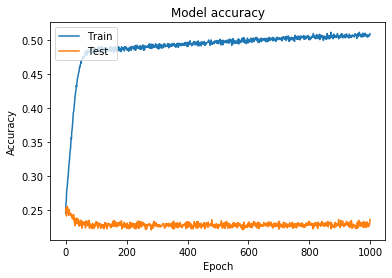

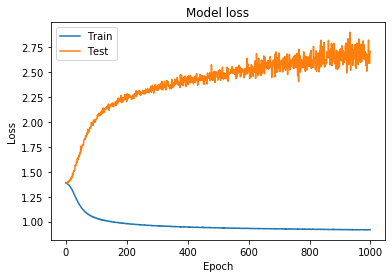

In [54]:
# To be continued............
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
'''
Create a model without assigning the Model Weight, and the Model has only 1 hidden layer with twice as many nodes as the input dimensionality
'''
def create_model_null():
    model = Sequential()
    model.add(Dense(128,input_dim = 22, activation = 'relu'))
    model.add(Dense(512,input_dim = 128, activation = 'relu'))
    model.add(Dense(128,input_dim = 512, activation = 'relu'))
    model.add(Dense(4,activation = 'softmax'))
    return model


'''
Model just with backpropagation
'''
def BP(X,Y):
    n = create_model_null()
    n.compile(optimizer = 'Adadelta', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    Count = 0
    # while Count < 10:
    # n.fit(X, Y, validation_split=0.2, epochs=100, batch_size=16, verbose=1, shuffle = True)
    history = n.fit(X, Y, validation_split=0.3, epochs=1000, batch_size=128, verbose=2, shuffle = True)
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
BP(X,Y)

In [55]:
Z = X.drop(["Age_0-9","Age_10-19","Age_20-24","Age_25-59","Age_60+","Gender_Female","Gender_Male","Gender_Transgender"], axis = 1)
Z

,Fever,Tiredness,Dry-Cough,Difficulty-in-Breathing,Sore-Throat,None_Sympton,Pains,Nasal-Congestion,Runny-Nose,Diarrhea,None_Experiencing,Contact_Dont-Know,Contact_No,Contact_Yes
163271,1,0,0,0,0,0,0,0,0,1,0,1,0,0
122252,0,0,0,0,1,0,1,1,1,0,0,1,0,0
234824,1,1,1,0,0,0,0,0,0,0,1,1,0,0
36460,1,0,0,0,0,0,1,1,0,0,0,0,1,0
231226,0,1,1,0,0,0,0,0,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208062,0,1,0,0,0,0,1,1,0,0,0,0,0,1
93241,1,1,1,0,0,0,0,1,1,1,0,0,1,0
161892,0,0,1,1,0,0,0,1,1,0,0,0,0,1
91613,0,1,1,1,0,0,1,1,1,1,0,1,0,0


In [56]:
target = []
for index,row in Y.iterrows():
    if row["Severity_None"] == 1:
        target.append(0)
    else:
        target.append(1)
#target

In [57]:
res = OneVsRestClassifier(LinearSVC(random_state=0)).fit(Z, target).predict(Z)
count = 0
for index in range(len(target)):
    if res[index] == target[index]:
        count+= 1
print(count / len(target))

0.7459280303030303
